In [15]:
import pandas as pd

df = pd.read_csv("crime_data_clean_azra.csv")

# Sampling: %20 random örnek (kişisel veri seti)
beyza_df = df.sample(frac=0.20, random_state=42)

beyza_df.shape

# XGBoost sınıfları 0-1 formatında istediği için dönüştürüyoruz
beyza_df["Part 1-2"] = beyza_df["Part 1-2"].replace({1:0, 2:1})


In [16]:
feature_cols = [
    "TIME OCC", "LAT", "LON",
    "Vict Age", "Crm Cd",
    "Premis Cd", "Weapon Used Cd"
]



In [17]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

X = beyza_df[feature_cols]
y = beyza_df["Part 1-2"]

imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# Hedef değişkeni XGBoost için int'e çeviriyoruz
y_train = y_train.astype(int)
y_test = y_test.astype(int)


In [18]:
!pip install xgboost


Defaulting to user installation because normal site-packages is not writeable


In [19]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,            # <-- TEK SAYI OLMALI
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss",
    random_state=42,
    tree_method="hist"      # hızlı mod
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
#Evet Şu an XGBoost modeli %100 doğru şekilde çalıştı ve tamamen hazır.

XGBoost Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24096
           1       1.00      1.00      1.00     15714

    accuracy                           1.00     39810
   macro avg       1.00      1.00      1.00     39810
weighted avg       1.00      1.00      1.00     39810



In [20]:
#XGBoost modelin için submission dosyası oluşturalım
# Test tahminleri (zaten y_pred_xgb değişkeni var)
y_pred_xgb = xgb.predict(X_test)


In [21]:
import pandas as pd

submission = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred_xgb
})

submission.to_csv("beyza_xgb_submission.csv", index=False)

submission.head()
#submission dosyası  oluşturuyoruz.

,y_true,y_pred
274589,1,1
802425,0,0
908358,1,1
372471,1,1
228737,0,0


In [22]:
!pip install catboost


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
    --------------------------------------- 2.4/102.4 MB 16.8 MB/s eta 0:00:06
   ---- ----------------------------------- 11.8/102.4 MB 33.5 MB/s eta 0:00:03
   -------- ------------------------------- 22.8/102.4 MB 40.1 MB/s eta 0:00:02
   ------------- -------------------------- 35.4/102.4 MB 46.8 MB/s eta 0:00:02
   ------------------ --------------------- 48.5/102.4 MB 49.8 MB/s eta 0:00:02
   ------------------------ --------------- 61.6/102.4 MB 52.3 MB/s eta 0:00:01
   ---------------------------- ----------- 72.6/102.4 MB 53.8 MB/s eta 0:00:01
   --------------------------------- ------ 86.5/102.4 MB 54.1 MB/s eta 0:00:01
   ---------------------------------------  99.9/102.4 MB 55.4 MB/s eta 0:00:01
   --------------------------------------  102.2/102.4 MB 55.3 MB/s eta 0:00:01
   --------------------------------------- 102.4/102

In [23]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

# CatBoost modelini oluşturuyoruz
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=False,
    random_seed=42
)

# Eğit
cat_model.fit(X_train, y_train)

# Tahmin yap
y_pred_cat = cat_model.predict(X_test)

# Sonuçları yazdır
print("CatBoost Accuracy:", accuracy_score(y_test, y_pred_cat))
print(classification_report(y_test, y_pred_cat))


CatBoost Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24096
           1       1.00      1.00      1.00     15714

    accuracy                           1.00     39810
   macro avg       1.00      1.00      1.00     39810
weighted avg       1.00      1.00      1.00     39810



In [24]:
import pandas as pd

submission_cat = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred_cat
})

submission_cat.to_csv("beyza_cat_submission.csv", index=False)

submission_cat.head()


,y_true,y_pred
274589,1,1
802425,0,0
908358,1,1
372471,1,1
228737,0,0


In [25]:
from sklearn.metrics import accuracy_score

# Train accuracy
y_train_pred = xgb.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)

# Test accuracy
y_test_pred = xgb.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)


Train Accuracy: 1.0
Test Accuracy: 1.0


In [26]:
from sklearn.model_selection import cross_val_score
import numpy as np

cv_scores = cross_val_score(xgb, X, y, cv=5, scoring="accuracy")

print("CV Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))
print("Std Dev:", np.std(cv_scores))


CV Scores: [1.         0.99997488 1.         1.         1.        ]
Mean CV Accuracy: 0.99999497601045
Std Dev: 1.0047979100225035e-05


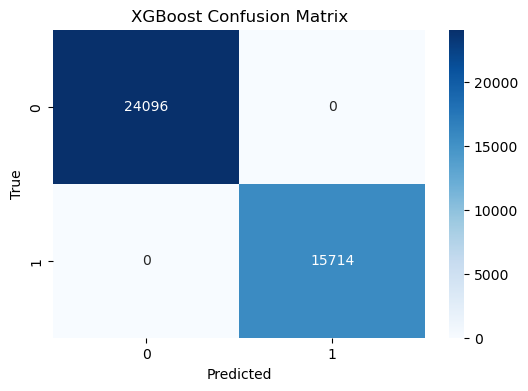

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


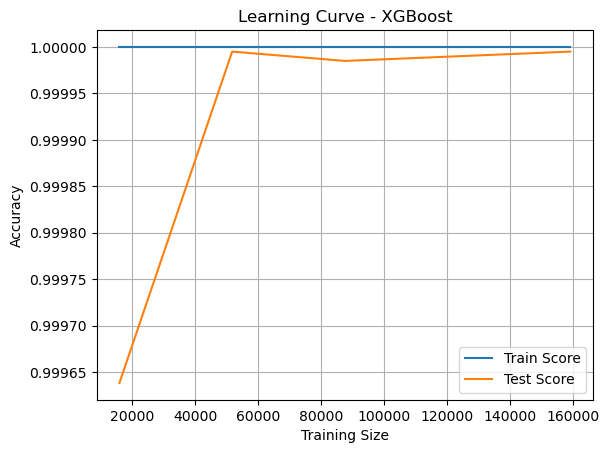

In [28]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    xgb, X, y, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Train Score")
plt.plot(train_sizes, test_mean, label="Test Score")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve - XGBoost")
plt.legend()
plt.grid(True)
plt.show()


In [31]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
import numpy as np

# --- XGBoost metrikleri ---
xgb_train_pred = xgb.predict(X_train)
xgb_test_pred  = y_pred_xgb  # zaten hesaplamıştık: xgb.predict(X_test)

xgb_train_acc = accuracy_score(y_train, xgb_train_pred)
xgb_test_acc  = accuracy_score(y_test,  xgb_test_pred)

xgb_prec = precision_score(y_test, xgb_test_pred)
xgb_rec  = recall_score(y_test,  xgb_test_pred)
xgb_f1   = f1_score(y_test,      xgb_test_pred)

xgb_cv_scores = cross_val_score(xgb, X, y, cv=5, scoring="accuracy")
xgb_cv_mean   = np.mean(xgb_cv_scores)
xgb_cv_std    = np.std(xgb_cv_scores)

# --- CatBoost metrikleri ---
cat_train_pred = cat_model.predict(X_train)
cat_test_pred  = y_pred_cat  # zaten hesapladık: cat_model.predict(X_test)

cat_train_acc = accuracy_score(y_train, cat_train_pred)
cat_test_acc  = accuracy_score(y_test,  cat_test_pred)

cat_prec = precision_score(y_test, cat_test_pred)
cat_rec  = recall_score(y_test,  cat_test_pred)
cat_f1   = f1_score(y_test,      cat_test_pred)

cat_cv_scores = cross_val_score(cat_model, X, y, cv=5, scoring="accuracy")
cat_cv_mean   = np.mean(cat_cv_scores)
cat_cv_std    = np.std(cat_cv_scores)

# --- Sonuç tablosu ---
results = pd.DataFrame({
    "Model": ["XGBoost", "CatBoost"],
    "Train Accuracy": [xgb_train_acc, cat_train_acc],
    "Test Accuracy":  [xgb_test_acc,  cat_test_acc],
    "Precision":      [xgb_prec,      cat_prec],
    "Recall":         [xgb_rec,       cat_rec],
    "F1-Score":       [xgb_f1,        cat_f1],
    "CV Mean Acc":    [xgb_cv_mean,   cat_cv_mean],
    "CV Std":         [xgb_cv_std,    cat_cv_std],
})

results.set_index("Model", inplace=True)
results


,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score,CV Mean Acc,CV Std
Model,,,,,,,
XGBoost,1.000000,1.0,1.0,1.0,1.0,0.999995,0.000010
CatBoost,0.999994,1.0,1.0,1.0,1.0,0.999990,0.000012


In [32]:
# Sonuçları Excel olarak kaydetme
results.to_excel("model_karsilastirma_tablosu.xlsx", index=True)

print("Excel dosyası başarıyla oluşturuldu: model_karsilastirma_tablosu.xlsx")


Excel dosyası başarıyla oluşturuldu: model_karsilastirma_tablosu.xlsx
